In [ ]:
# import sys
# !{sys.executable} -m pip install nltk

In [ ]:
!pip install selenium
!pip install wordcloud

import nltk

# Download the stopwords data
nltk.download('stopwords')

#Download the wordnet Data
nltk.download('wordnet')

nltk.download('omw-1.4')

# Now you should be able to use the stopwords data
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException

import time


url = "https://www.argos.co.uk/product/9461987?clickSR=slp:term:meta%20quest%202:2:22:1"


driver = webdriver.Chrome()
driver.get(url)
print(driver.title)

# press cookies button
cookie = driver.find_element(By.ID, 'consent_prompt_submit')
cookie.click()

# opens the review section
reviewsBtn = driver.find_element(By.ID, 'reviews')
reviewsBtn.click()

currentPage = 1
maxPages = 50

while currentPage <= maxPages:
    time.sleep(3)
    # stores the path of show more button, and then clicks on it
    btn_XPATH = '//*[@id="reviews-accordion-accordion-content-reviews-accordion"]/div/div/div/div[2]/div[2]/span[' + str(currentPage) + '1]/button'
    print(btn_XPATH)
    try:
        showMoreBtn = driver.find_element(By.XPATH, btn_XPATH)
        showMoreBtn.click()
        currentPage += 1
    except NoSuchElementException:
        # element was not found, so we continue the loop
        currentPage += 1
        continue

    

reviews_section = driver.find_element(By.ID, 'reviews-accordion-accordion-content-reviews-accordion')  
reviews = reviews_section.find_elements(By.TAG_NAME, 'p')
scraped_timestamp = reviews_section.find_elements(By.TAG_NAME, 'time')

reviews_list = []
for review in reviews:
    reviews_list.append(review.text)


timestamps = []
for time in scraped_timestamp:
    datetime = time.get_attribute("datetime")
    timestamps.append(datetime)




In [ ]:
import pandas as pd

# Set the maximum length of the string to display
pd.set_option('display.max_colwidth', None)

# Create a DataFrame
df = pd.DataFrame(reviews_list)

# Print the full contents of the DataFrame starting from Index 2
display(df.iloc[3:])
df.to_csv('test.csv')

In [ ]:
# Remove the first three elements from the list
del reviews_list[0:3]
df = pd.DataFrame(reviews_list)
df

In [ ]:
# Create a new dataframe by splitting the the content of the 2nd row into 3 columns
# every 3 steps starting from 0, 1, and 2
new_df = pd.DataFrame(df.values.reshape(-1, 3),
                      columns=['title', 'reviews', 'location'])

# Print the resulting dataframe
new_df

In [ ]:
# Add the list as a new 2nd column to the dataframe
new_df.insert(loc=2, column='timestamp', value=timestamps[:510])
new_df

In [ ]:
new_df.to_csv('data.csv')

In [1]:
import pandas as pd
import csv

try:
    # Read the CSV file into a dataframe
    df = pd.read_csv('data.csv')
except Exception as e:
    print("Error opening file:", e)
    
df.isnull().sum()

Unnamed: 0    0
title         0
reviews       0
timestamp     0
location      0
dtype: int64

In [2]:
# Drop column 'Unnamed: 0'
df.drop(columns=['Unnamed: 0'], inplace=True)
# Print the data type of each column
print(df.dtypes)

title        object
reviews      object
timestamp    object
location     object
dtype: object


In [3]:
from datetime import datetime

### https://stackabuse.com/how-to-format-dates-in-python/

# function gets string of datetime as a parameter
# converts the string into datetime object
# returns the datetime object

def convert_str_to_datetime(str):
    # Format string: "%Y-%m-%dT%H:%M:%S.%fZ"
    # %Y returns the year (YYYY)
    # %m returns the month (MM)
    # %d returns the day (DD)
    # %H returns the hour (HH, 24h format)
    # %M returns the minute (MM)
    # %S returns the second (SS)
    # %f returns the microsecond (ff)
    # Z returns the time zone (literal "Z" for UTC time)
    datetime_format = "%Y-%m-%dT%H:%M:%S.%fZ"

    # Try to convert the string to a datetime object
    try:
        datetime_object = datetime.strptime(str, datetime_format)
    except ValueError:
        # If the parsing fails, set the datetime_object to None
        datetime_object = None
    
    return datetime_object
    

# iterate through the rows of the timestamp column 
for index, row in df.iterrows():
    # access value of the row in timestamp column
    value = row['timestamp']
    
    # checks if type value is a string
    if type(value) == str:
        # update the value in the original DataFrame to a datetime.datetime
        try:
            df.at[index, 'timestamp'] = convert_str_to_datetime(value)
        except Exception as e:
            # handle the exception error
            print(e)
 

In [4]:
import re
def get_city_location(row):
    # access value of the row in location column and stores it in value variable
    value = row['location']
    complete_location = re.split(r",", value)
    try:
        #third element gives us the name of the city of the customer
        city_location = complete_location[2]
    except:
        # sets it to N/A 
        city_location = "N/A"
    
    return city_location

# apply the extract_city_location() function to each row of the dataframe in the location column
df['location'] = df.apply(get_city_location, axis=1)

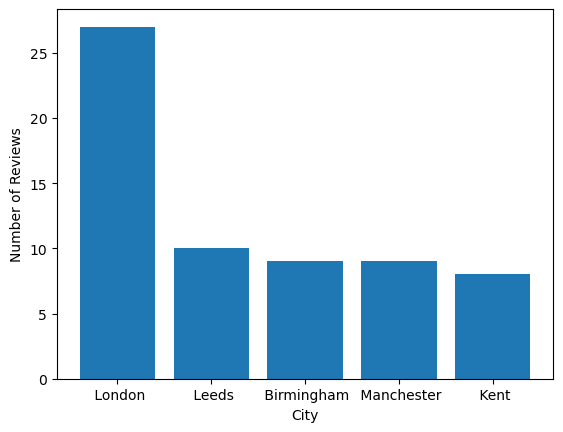

In [6]:
import matplotlib.pyplot as plt
#create a new df that contains all the cities that isnt N\A
filtered_df = df.loc[df['location'] != 'N/A']

# get the top cities by using counter then sorting the values and finally get only the first 5
top_cities = filtered_df['location'].value_counts().sort_values(ascending=False).head(5)

# Plot a bar chart of review counts by city
plt.bar(top_cities.index, top_cities)
plt.xlabel('City')
plt.ylabel('Number of Reviews')
# show the plot
plt.show()

In [7]:
### https://stackoverflow.com/questions/18429143/strip-punctuation-with-regex-python ###

# function that removes special characters, punctuations, extra whitespace from text
def strip_special_characters(text):    
    # compile a regular expression pattern that matches one or more spaces
    pattern = re.compile('\s+')
    
    # removes any special characters and punctuations from text
    clean_text = re.sub(r'[^\w\s]',' ',text)
    
    # renoves any underscore from the text
    clean_text = re.sub(r'_',' ',clean_text)
    
    #removes exccess white space from the text
    clean_text = pattern.sub(' ', clean_text)
    
    #returns the text clean from special characters, punctuations, underscore and exccess white space
    return clean_text


# iterate through the rows of the reviews column 
for index, row in df.iterrows():
    # access value of the row in reviews column
    text = row['reviews']
    
    # checks if type of text is a string
    if type(text) == str:
        # update the text in the original DataFrame
        try:
            df.at[index, 'reviews'] = strip_special_characters(text)
        except Exception as e:
            # handle the exception error
            print(e)

In [8]:
# Set the maximum length of the string to display
pd.set_option('display.max_colwidth', None)
df

,title,reviews,timestamp,location
0,Present for daughter,I bought this for a Christmas present for my daughter very happy with the delivery ewas delivered with care,2022-12-14 00:00:00,Prescot
1,Meta Quest 2,Excellent value for money Happy customer would definitely recommend,2022-12-13 00:00:00,Teesside
2,Meta quest 2,The best thing I ve ever brought and owned Love playing the games so much fun,2022-12-13 00:00:00,Mansfield
3,Awesome headset,This is the first VR headset I have ever owned but both me and my partner are very impressed with it So delighted that it also has a glasses spacer included Overall I m really impressed with it Please be aware that if using with a PC you can only have 1 active monitor whilst using it otherwise the headset will have a glitchy connection and the visuals around you are distorted laggy and it almost looks like you re surrounded by a warping void whilst wearing the headset Turning off one of my 2 monitors hasn t worked so I m yet to fix that by trying to completely disconnect the secondary monitor The one con I have to mention is that it seems to be sliding forward quite a bit which can be disruptive to the game play and I m considering purchasing the elite strap potentially the one with a battery to balance the weight of it a bit,2022-12-13 00:00:00,Bristol
4,So much fun,I bought this for my 13 year old nephews birthday and it was so easy to set up and start using We set up the meta account in just a few mins and bought some games at the same time The whole family tried it and it was so much fun and easy to use I would definitely recommend this for anyone even a non gamer like me The only problem is we had to keep charging it but that may be because we couldn t wait until it was fully charged to start using it,2022-12-07 00:00:00,Bookham
...,...,...,...,...
505,Fantastic (oculus),I had bought the oculus for my son thinking it oil s been like the other VR BRANDS but know these are next level The boys asked me play it now I can t stop playing absolutely loving it,2022-02-01 00:00:00,London
506,Honest review,The headstrap is fine it doesnt feel too front heavy The battery life is fine I get tired after one hour anyway Any USB 3 rated for transfer can be used don t buy the official one Use a referral link to get store credit The TOS is iffy but soon it should change as the Facebook account requirement is going to be removed,2022-02-01 00:00:00,N/A
507,"Portable, fun gaming gear",Bought this for some family fun and everybody uses it at home Great picture and features portability is a bonus without the need for a console However the screen can be cast to a TV that supports it or Amazon fire stick with an app Battery life is reasonable but I have bought an extra long charge lead so it can be worn while plugged in,2022-02-01 00:00:00,Margate
508,Great Product and fun for all the family!,Purchased this for my 9 year old sons birthday He absolutely loves it There s plenty of free games and experiences and I would definitely recommend it Also very smooth purchase and delivery from Argos,2022-02-01 00:00:00,Southend on Sea


In [9]:
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from gensim import corpora, models

In [14]:
# lowercase text
def get_lowercase(text):
    return [word.lower() for word in text]

# tokenize the reviews text 

### lab 5 ### 
### https://www.geeksforgeeks.org/removing-stop-words-nltk-python/ ###

def strip_stop_words(text):
    try:
        stop_words = set(stopwords.words('english'))
        cleaned = [word for word in text if word not in stop_words]
        return cleaned
    except:
        # return empty list
        return []
# Lemmatization is generally more accurate than stemming
# If the context in which the words are used is important, lemmatization may be a better choice
# preserve the original meaning of the words and improve the accuracy of the analysis


### https://www.geeksforgeeks.org/python-lemmatization-with-nltk/ ###
from nltk.stem import WordNetLemmatizer

### if not all(isinstance(x, str) ###


def lemmatize_words(text):        
    try:
        lemmatizer = WordNetLemmatizer()
        cleaned = [lemmatizer.lemmatize(word) for word in text]
        return cleaned
    except:
        # return empty list
        return []
    
def concatenate_words(text):
    # checks if the input is a list or a string
    if isinstance(text, list):
        tokens = []
        for word in text:
            # Convert each word to a string and add it to the list of tokens
            tokens.append(str(word))
        # Concatenate the tokens with a space separator
        return ' '.join(tokens)
    # checks if the input is a string, return it as is
    if isinstance(text, str):       
        return text    

In [13]:
df['reviews'] = df['reviews'].apply(word_tokenize)
df['reviews'] = df['reviews'].apply(get_lowercase)
df['reviews'] = df['reviews'].apply(strip_stop_words)
df['reviews'] = df['reviews'].apply(lemmatize_words)
df

,title,reviews,timestamp,location
0,Present for daughter,I bought this for a Christmas present for my daughter very happy with the delivery ewas delivered with care,2022-12-14 00:00:00,Prescot
1,Meta Quest 2,Excellent value for money Happy customer would definitely recommend,2022-12-13 00:00:00,Teesside
2,Meta quest 2,The best thing I ve ever brought and owned Love playing the games so much fun,2022-12-13 00:00:00,Mansfield
3,Awesome headset,This is the first VR headset I have ever owned but both me and my partner are very impressed with it So delighted that it also has a glasses spacer included Overall I m really impressed with it Please be aware that if using with a PC you can only have 1 active monitor whilst using it otherwise the headset will have a glitchy connection and the visuals around you are distorted laggy and it almost looks like you re surrounded by a warping void whilst wearing the headset Turning off one of my 2 monitors hasn t worked so I m yet to fix that by trying to completely disconnect the secondary monitor The one con I have to mention is that it seems to be sliding forward quite a bit which can be disruptive to the game play and I m considering purchasing the elite strap potentially the one with a battery to balance the weight of it a bit,2022-12-13 00:00:00,Bristol
4,So much fun,I bought this for my 13 year old nephews birthday and it was so easy to set up and start using We set up the meta account in just a few mins and bought some games at the same time The whole family tried it and it was so much fun and easy to use I would definitely recommend this for anyone even a non gamer like me The only problem is we had to keep charging it but that may be because we couldn t wait until it was fully charged to start using it,2022-12-07 00:00:00,Bookham
...,...,...,...,...
505,Fantastic (oculus),I had bought the oculus for my son thinking it oil s been like the other VR BRANDS but know these are next level The boys asked me play it now I can t stop playing absolutely loving it,2022-02-01 00:00:00,London
506,Honest review,The headstrap is fine it doesnt feel too front heavy The battery life is fine I get tired after one hour anyway Any USB 3 rated for transfer can be used don t buy the official one Use a referral link to get store credit The TOS is iffy but soon it should change as the Facebook account requirement is going to be removed,2022-02-01 00:00:00,N/A
507,"Portable, fun gaming gear",Bought this for some family fun and everybody uses it at home Great picture and features portability is a bonus without the need for a console However the screen can be cast to a TV that supports it or Amazon fire stick with an app Battery life is reasonable but I have bought an extra long charge lead so it can be worn while plugged in,2022-02-01 00:00:00,Margate
508,Great Product and fun for all the family!,Purchased this for my 9 year old sons birthday He absolutely loves it There s plenty of free games and experiences and I would definitely recommend it Also very smooth purchase and delivery from Argos,2022-02-01 00:00:00,Southend on Sea


In [ ]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Prepare the text
text = ['This', 'first', 'VR', 'headset', 'I', 'ever', 'owned', 'partner', 'impressed', 'So', 'delighted', 'also', 'glasses', 'spacer', 'included', 'Overall', 'I', 'really', 'impressed', 'Please', 'aware', 'using', 'PC', '1', 'active', 'monitor', 'whilst', 'using', 'otherwise','headset']
### https://programminghistorian.org/en/lessons/counting-frequencies ###

def get_word_freq(tokens):
    # Create a dictionary of word frequencies
    word_freq = {}
    for word in tokens:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    return word_freq

def display_word_freq(word_freq, tokens):
    # Create the word cloud object
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_freq)

    # Generate the word cloud
    text = ' '.join(tokens)
    wordcloud.generate(text)

    # Convert the word cloud to a NumPy array
    image = wordcloud.to_array()

    # Display the image using imshow
    plt.imshow(image)

    # Hide the axis labels
    plt.axis("off")

    # Show the plot
    plt.show()
    


In [15]:
# using sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def calculate_sentiment_percent(sentiment):
    # validates if the the dictionary has the correct keys pos, neg and neu   
    keys = {'pos', 'neg', 'neu'}
    if not keys.issubset(sentiment.keys()):
        raise ValueError('dictionary must have the following three keys: "pos", "neg", "neu"')
        
    # Calculate the percentage of positive, negative, and neutral sentiments
    total = sum(sentiment.values())
    pos_percent = sentiment['pos'] / total * 100
    neg_percent = sentiment['neg'] / total * 100
    neu_percent = sentiment['neu'] / total * 100
    
    # returns the percentage of positive, negative, and neutral sentiments
    return pos_percent, neg_percent, neu_percent

def classify_sentiment(tokens):
    text = concatenate_words(tokens)
    # validates if the the input is a string
    if not isinstance(text, str):
        return {'sentiment': 'error', 'pos_percent': 0, 'neg_percent': 0, 'neu_percent': 0}

    try:
        sid = SentimentIntensityAnalyzer()
        sentiment = sid.polarity_scores(text)

        pos_percent, neg_percent, neu_percent = calculate_sentiment_percent(sentiment)

        if sentiment['compound'] >= 0.05:
            return {'sentiment': 'positive', 'pos_percent': pos_percent, 'neg_percent': neg_percent, 'neu_percent': neu_percent}
        elif sentiment['compound'] <= -0.05:
            return {'sentiment': 'negative', 'pos_percent': pos_percent, 'neg_percent': neg_percent, 'neu_percent': neu_percent}
        else:
            return {'sentiment': 'neutral', 'pos_percent': pos_percent, 'neg_percent': neg_percent, 'neu_percent': neu_percent}
    except:
        return {'sentiment': 'N\A', 'pos_percent': 0, 'neg_percent': 0, 'neu_percent': 0}


# example usage

In [16]:
pd.set_option('display.max_rows', 500)

df['sentiment'] = df.apply(lambda row: classify_sentiment(row['reviews'])['sentiment'], axis=1)

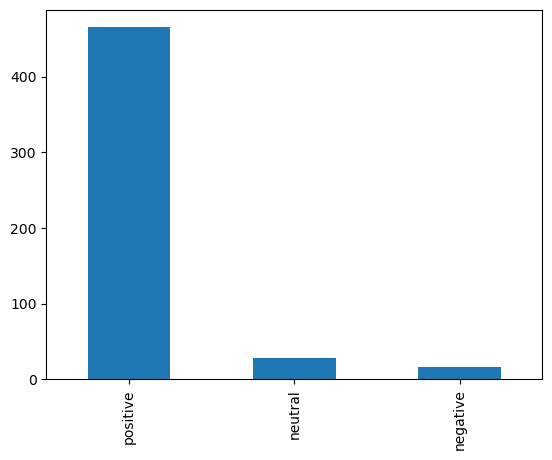

In [17]:
import matplotlib.pyplot as plt
#Assume df is your Pandas DataFrame and 'column' is the column you want to plot
counts = df['sentiment'].value_counts().sort_values(ascending=False)

# Plot the counts as a bar plot
counts.plot(kind='bar')

# Show the plot
plt.show()

In [ ]:
# Extract the month and year from the timestamp
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year

# Group the data by month and year and compute the mean
mean_by_month_year = df.groupby(['month', 'year']).mean()

# Plot the data
plt.plot(mean_by_month_year)
plt.xlabel('Month and Year')
plt.ylabel('Mean Value')
plt.title('Mean Value by Month and Year')
plt.xticks(rotation=45)

# Add a trendline
z = np.polyfit(mean_by_month_year.index.get_level_values(1), mean_by_month_year, 1)
p = np.poly1d(z)
plt.plot(mean_by_month_year.index, p(mean_by_month_year.index.get_level_values(1)), "r--")

plt.show()

In [ ]:
df['timestamp'].dtype

In [ ]:
# First, we need to install the necessary libraries
#!pip install nltk gensim

# Next, we'll import the libraries we'll need
import nltk
import gensim
from gensim import corpora

# Let's say we have a list of documents, where each document is a list of tokens
documents = [
    ['cat', 'dog', 'mouse', 'rat'],
    ['dog', 'rat', 'bat'],
    ['cat', 'bat', 'rat', 'rat'],
    ['cat', 'dog', 'bat'],
]

# We'll need to preprocess the documents by lowercasing and stemming the tokens
# You may also want to remove stop words and other extraneous words at this step

# We'll use the Porter stemmer from the nltk library to stem the tokens
porter_stemmer = nltk.stem.porter.PorterStemmer()

preprocessed_documents = []
for doc in df.reviews.iloc[:100]:
    preprocessed_documents.append([porter_stemmer.stem(token) for token in doc])

# Now we'll create a dictionary from the preprocessed documents
dictionary = corpora.Dictionary(preprocessed_documents)

# Next, we'll create a bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in preprocessed_documents]

# Now we're ready to perform topic modeling using LDA
num_topics = 2  # let's say we want to extract 2 topics

# Initialize the LDA model
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary)

# Let's see what the topics are
print(lda_model.print_topics())


In [18]:
#!pip install bertopic
from bertopic import BERTopic

docs = df.reviews
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)


In [19]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,129,-1_it_and_for_the
1,0,141,0_the_to_and_it
2,1,74,1_happy_product_this_ago
3,2,66,2_it_for_and_this
4,3,43,3_birthday_for_my_it
5,4,31,4_loves_my_son_bought
6,5,16,5_fun_family_of_for
7,6,10,6_you_need_it_to


In [20]:
df["topic"] = topics

In [21]:
# shows the representative docs
topic_model.representative_docs_[5]

['Brilliant for the family to play hours of fun ',
 'Loved it Good fun Good fun ',
 'Great family fun ']

In [22]:
# breakdown sentiment by topic
topic_sentiment = {}
for topic, df_ in df.groupby("topic"):
    topic_sentiment[topic] = df_["sentiment"].value_counts() / len(df_) * 100
pd.DataFrame(topic_sentiment)

,-1,0,1,2,3,4,5,6
negative,2.325581,3.546099,8.108108,3.030303,2.325581,NaN,NaN,NaN
neutral,8.527132,1.418440,5.405405,1.515152,18.604651,3.225806,NaN,10.0
positive,89.147287,95.035461,86.486486,95.454545,79.069767,96.774194,100.0,90.0


In [23]:
print(topic_sentiment)

{-1: positive    89.147287
neutral      8.527132
negative     2.325581
Name: sentiment, dtype: float64, 0: positive    95.035461
negative     3.546099
neutral      1.418440
Name: sentiment, dtype: float64, 1: positive    86.486486
negative     8.108108
neutral      5.405405
Name: sentiment, dtype: float64, 2: positive    95.454545
negative     3.030303
neutral      1.515152
Name: sentiment, dtype: float64, 3: positive    79.069767
neutral     18.604651
negative     2.325581
Name: sentiment, dtype: float64, 4: positive    96.774194
neutral      3.225806
Name: sentiment, dtype: float64, 5: positive    100.0
Name: sentiment, dtype: float64, 6: positive    90.0
neutral     10.0
Name: sentiment, dtype: float64}


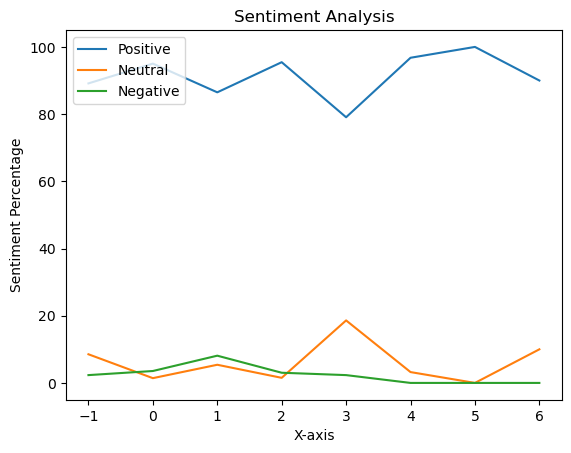

In [24]:
import matplotlib.pyplot as plt

# get the values from the topic_sentiment dict and store them in separate lists
x_values = list(topic_sentiment.keys())
positive_values = []
neutral_values = []
negative_values = []

for key, value in topic_sentiment.items():
    if 'positive' in value:
        positive_values.append(value['positive'])
    else:
        positive_values.append(0)
    if 'neutral' in value:
        neutral_values.append(value['neutral'])
    else:
        neutral_values.append(0)
    if 'negative' in value:
        negative_values.append(value['negative'])
    else:
        negative_values.append(0)

# Create the line chart
plt.plot(x_values, positive_values, label='Positive')
plt.plot(x_values, neutral_values, label='Neutral')
plt.plot(x_values, negative_values, label='Negative')

# Add a title and axis labels
plt.title('Sentiment Analysis')
plt.xlabel('X-axis')
plt.ylabel('Sentiment Percentage')

# Add a legend
plt.legend(loc='upper left')

# Show the plot
plt.show()

In [29]:
df[(df.topic == 5)]

,title,reviews,timestamp,location,sentiment,topic
14,Vr,Can t give an honest review other than it was expensive to purchase and it s a Xmas gift wich is still sealed in its box because if i undo it I can t return if my kid decides it don t want it so i have to wait till Xmas day to leave a proper review,2022-11-23 00:00:00,Plumstead,positive,3
21,Great purchase,Bought for sons 12th birthday he loves it Would make an ideal Christmas present,2022-11-15 00:00:00,Durham,positive,3
26,Great buy,Bought for my son s 10th birthday He s over the moon with his present,2022-11-09 00:00:00,London,neutral,3
28,Brilliant,For a Xmas Present For my kids Looks Amazing,2022-11-08 00:00:00,Downpatrick,positive,3
29,Meta quest 2,I got this for my son birthday he loves it Family fun,2022-11-07 00:00:00,West Yorkshire,positive,3
34,Great,Bought for daughters birthday she loves it,2022-11-02 00:00:00,Redcar,positive,3
36,What he wanted for Xmas,Bought for Xmas present for Grandson do not know anything about it,2022-10-26 00:00:00,N/A,neutral,3
47,My Review for Meta Quest 2 128GB All-in-One VR Hea,I bought them for my grandsons for Christmas so not sure if any good but that is what i was advised to buy Can t really answer any of the questions below really,2022-10-18 00:00:00,Bolton,positive,3
55,Great features,I brought this for my sons birthday he absolutely loves playing on it best thing I have got him,2022-10-11 00:00:00,Bletchley,positive,3
63,Meta quest,Brill present for my grandchildren,2022-09-28 00:00:00,Liverpool,neutral,3


In [ ]:
! pip install keybert

In [26]:
from keybert import KeyBERT
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(df[df.topic == 5]["reviews"].to_list())# keyphrase_ngram_range=(1))

In [27]:
from collections import Counter

# sorted_keywords is a list of tuples where.
# each tuple consists of a keyword and its frequency.
# The list is sorted in descending order of frequency by applying the sorted function.
# display only the 10 first.
sorted_keywords = sorted(Counter([xx[0] for x in keywords for xx in x]).items(), key=lambda x: x[1], reverse=True)[:10]
sorted_keywords

[('fun', 16),
 ('family', 8),
 ('great', 4),
 ('hours', 3),
 ('brilliant', 3),
 ('son', 2),
 ('good', 2),
 ('excellent', 2),
 ('best', 2),
 ('ages', 2)]

In [31]:
topic_num = 5
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(df[df.topic == topic_num]["reviews"].to_list())# keyphrase_ngram_range=(1))
# sorted_keywords is a list of tuples where.
# each tuple consists of a keyword and its frequency.
# The list is sorted in descending order of frequency by applying the sorted function.
# display only the 10 first.
sorted_keywords = sorted(Counter([xx[0] for x in keywords for xx in x]).items(), key=lambda x: x[1], reverse=True)[:10]
sorted_keywords


[('fun', 16),
 ('family', 8),
 ('great', 4),
 ('hours', 3),
 ('brilliant', 3),
 ('son', 2),
 ('good', 2),
 ('excellent', 2),
 ('best', 2),
 ('ages', 2)]

In [ ]:
concatenate_words(df[df.topic == 5]["reviews"].to_list())

In [ ]:
# gets the first element of each tuple. (frequency)
keywords = [keyword for keyword, frequency in sorted_keywords]

# gets the the second element of each tuple. (keyword)
frequencies = [frequency for keyword, frequency in sorted_keywords]

print(keywords)
print(frequencies)

from wordcloud import WordCloud
def generate_word_cloud(sorted_keywords):
    # Create a dictionary from the sorted_keywords list
    keyword_frequencies = dict(sorted_keywords)

    # Create the word cloud
    wordcloud = WordCloud(width=400, height=400, 
                          background_color='white', 
                          min_font_size=10).generate_from_frequencies(keyword_frequencies)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Create the word cloud
generate_word_cloud(sorted_keywords)

# TOPIC 1
we can see from this wordcloud that theres a frequent use of words
of son and grandson which suggests relationship, birthday," "present," and "xmas" suggests that the text may be related to celebrations or gift-giving.


In [ ]:
def generate_barh(keywords, frequencies):
    # checks if the keywords and frequencies have the same length
    if len(keywords) != len(frequencies):
        return 'keywords and frequencies are not the same len'
    
    # Create the bar chart
    plt.barh(keywords, frequencies, height=0.4, color='#228b22')

    # Set the tick labels for the y-axis
    plt.yticks(keywords, keywords)

    # Add labels and the title
    plt.ylabel('Keywords')
    plt.xlabel('Frequency')
    plt.title('Keyword Frequencies')

    # displays the plot
    plt.show()
    
generate_barh(keywords, frequencies)